# 3.2 En este notebook exploraremos estrategias para optimizar los mecanismos de DP utilizados sobre el set de datos que contiene los registros de causas que NO corresponden a violencia de género (Set de datos II). 

In [ ]:
!pip install diffprivlib

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from scipy import stats
import diffprivlib as dp
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def kl(p, q):
    """Kullback-Leibler divergence D(P || Q) for discrete distributions
    Parameters
    ----------
    p, q : array-like, dtype=float, shape=n
    Discrete probability distributions.
    """
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)
    q= np.where(q == 0, 0.000000001, q)

    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_colwidth', None)

In [ ]:
###Conecto al drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
###Cargo Dataset procesado 
ds = pd.read_csv('/content/gdrive/MyDrive/dataset_gral_pro.csv', index_col=0)

In [ ]:
ds.head()

,CODIGO_O_LEY,NACIONALIDAD_ACUSADO/A,EDAD_ACUSADO/A AL MOMENTO DEL HECHO,LUGAR_DEL_HECHO\n,TIPO_DE_RESOLUCION,OBJETO_DE_LA_RESOLUCION,DECISION
NRO_REGISTRO,,,,,,,
0708,codigo_penal_de_la_nacion,s/d,s/d,mediante_medios_tecnológicos,interlocutoria,cuestion_de_competencia,hace_lugar
0709,NaN,s/d,s/d,en_domicilio_laboral,definitiva,medida_probatoria,no_hace_lugar
0710,NaN,s/d,s/d,en_domicilio_laboral,definitiva,medida_probatoria,no_hace_lugar
0711,codigo_contravencional,argentina,50_o_mas,en_domicilio_laboral,interlocutoria,medida_cautelar,hace_lugar
0711bis,codigo_penal_de_la_nacion,argentina,entre_18_30,mediante_medios_tecnológicos,interlocutoria,cuestion_de_competencia,no_hace_lugar


## 3.2.1 Evaluando diferentes mecanismos

Al igual que hicimos en el notebook 2.2, vamos a comparar diferentes mecanismos de DP aplicados a este conjunto de datos. Aunque en el conjunto anterior sepamos qué es lo que funcionó mejor, no quiere decir que en este será igual. Al margen de las diferencias entre los registros individuales, la clave a considerar es la diferencia en el número de consultas que estaremos realizando y en el tamaño del dataset. 

In [ ]:
mech = ['lap', 'gauss']
budgets = [0.5,1,2,3,4,5,6,7]
error_budget = []

for b in budgets: 

  error_mech = []
  epsilon = b/len(ds.columns)

  for m in mech:

    if m == 'gauss':
      sens = np.sqrt(len(ds.columns))
      delta = 0.0005
    else:
      sens = len(ds.columns)
      delta = 0

    divergencia_kl_budget_bin = []
    error_absoluto_budget_bin = []

    for i in range(0,1000):

      div_kl_hist = []
      error_abs_hist = []
      for (columnName, columnData) in ds.iteritems():
        
      
        codes = pd.Categorical(columnData).codes###Extraigo la codificación numérica correspondiente a cada categoría. Es necesario para el funcionamiento de la función np.histogram
        n_cat = len(np.unique(codes))###Calculo la cantidad de bins que utilizará la función histograma, que será uno por categoría de la variable.

        ###CON DP
        dp_hist, dp_bins = dp.tools.histogram(codes, mech=m, epsilon=epsilon, delta=delta, sens=sens, bins=n_cat)

        ###Sin DP
        hist, bins = np.histogram(codes, bins=n_cat)
        hist = hist / hist.sum()

        ###Error
        div_kl_hist.append(kl(hist, dp_hist))
        error_abs_hist.append(np.abs(hist - dp_hist).sum())

      divergencia_kl_budget_bin.append(div_kl_hist)
      error_absoluto_budget_bin.append(error_abs_hist)

    divergencia_kl_budget_bin = np.mean(divergencia_kl_budget_bin, axis=0)
    error_absoluto_budget_bin = np.mean(error_absoluto_budget_bin, axis=0)

    error_mech.append([b, m, np.mean(divergencia_kl_budget_bin), np.mean(error_absoluto_budget_bin)])
  error_budget.append(pd.DataFrame(error_mech))

error_budget = pd.concat(error_budget)
error_budget.columns = ['Budget', 'Mecanismo', 'Divergencia KL', 'Error Absoluto']

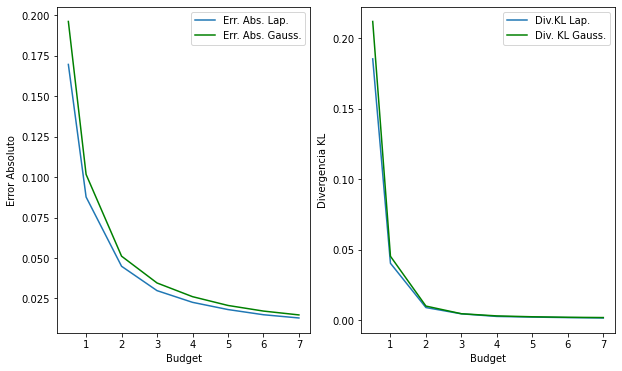

In [ ]:
error_lap = error_budget.loc[error_budget.Mecanismo == 'lap', :]
error_gauss = error_budget.loc[error_budget.Mecanismo == 'gauss', :]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (10, 6))

axs[0].plot(error_lap['Budget'], error_lap['Error Absoluto'])
axs[0].plot(error_lap['Budget'], error_gauss['Error Absoluto'], color='green')
axs[0].set_xlabel('Budget')
axs[0].set_ylabel('Error Absoluto')
axs[0].legend(['Err. Abs. Lap.', 'Err. Abs. Gauss.'])

axs[1].plot(error_lap['Budget'], error_lap['Divergencia KL'])
axs[1].plot(error_lap['Budget'], error_gauss['Divergencia KL'], color='green')
axs[1].set_xlabel('Budget')
axs[1].set_ylabel('Divergencia KL')
axs[1].legend(['Div.KL Lap.', 'Div. KL Gauss.'])

###fig.suptitle('Error del mecanismo DP en función del budget asignado')


In [ ]:
error_budget.reset_index(drop=True)

,Budget,Mecanismo,Divergencia KL,Error Absoluto
0,0.5,lap,0.185451,0.169673
1,0.5,gauss,0.211951,0.196243
2,1.0,lap,0.040548,0.087720
3,1.0,gauss,0.045508,0.101672
4,2.0,lap,0.009150,0.044879
5,2.0,gauss,0.010206,0.051121
6,3.0,lap,0.004710,0.029813
7,3.0,gauss,0.004779,0.034550
8,4.0,lap,0.002861,0.022583
9,4.0,gauss,0.003235,0.026089


El punto central a señalar de estos resultados es que a diferencia de lo que veíamos con el set de datos I, ya no es el mecanismo gaussiano el que garantiza mejores resultados en nuestro experimento, sino el laplaciano. Para todo el conjunto de presupuestos evaluados, este mecanismo logró mejores resultados en este dataset en particular. Esto se debe a que la sensibilidad de la consulta es baja, y el mecanismo laplaciano suele obtener mejores resultados en casos de consultas de sensibilidad baja. Para comprender mejor lo que está pasando, veamos las respectivas distribuciones de las que los mecanismos adicionan el ruido.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


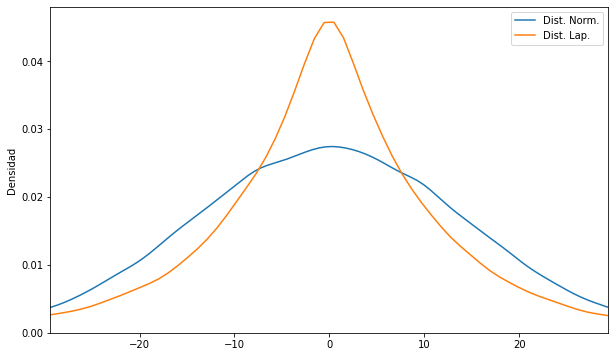

In [ ]:
delta = 0.0005
epsilon = 5/len(ds.columns)
sensL2 = np.sqrt(len(ds.columns))
escala_norm = np.sqrt(2 * np.log(1.25 / delta)) * sensL2 / epsilon
value_norm = np.random.normal(loc=0,scale=escala_norm,size=100000)
sensL1 = len(ds.columns)
escala_lap = sensL1 / epsilon
value_lap = np.random.laplace(loc=0,scale=escala_lap,size=100000)
plt.figure(figsize=(10, 6))
fig = sns.distplot(value_norm, hist = False)
sns.distplot(value_lap, hist = False)
fig.set_xlim([-escala_lap*3, escala_lap*3])
fig.set_ylabel('Densidad')
fig.legend(['Dist. Norm.', 'Dist. Lap.'])

En este caso la distribución laplaciana tiene una densidad cercana al centro muy superior  a la de la normal. Esto quiere decir que utilizando esta distribución para muestrear el ruido, la probabilidad de tomar valores cercanos al centro es bastante mayor que utilizando una distribución normal. En cambio, la desventaja de la distribución laplaciana, que son las colas largas que acumulan una importante densidad en los extremos, no son tan relevantes en este caso, ya que acumulan mucha menos densidad que en el caso anterior. Por el contrario, la distribución normal, al ser más achatada, tiene mayor densidad acumulada en regiones alejadas del centro. Por ello, utilizando el mecanismo gaussiano la probabilidad de agregar valores de ruido elevados es mayor que si se utiliza el mecanismo laplaciano.

Dado que ya establecimos en el notebook 2.2 que un budget de 4 es óptimo para el conjunto de datos de violencia de género, y en este conjunto de datos el error en la salida es muy inferior, determinaremos ese presupuesto de 4 $\epsilon$ como definitivo. De ahora en adelante, los cómputos que haremos serán  considerando únicamente un budget de 4 $\epsilon$.

## 3.2.2 Distribuyendo el budget entre features y categorías

Veamos a continuación si la estrategia de asignación del budget que definimos previamente es válida para este conjunto de datos. 

#### Evaluemos el error de la salida realizando la asignación del budget de forma pareja entre todos los features.

In [ ]:
### A todos features les doy mismo budget
budget = 4
epsilon = budget/len(ds.columns)###Distribuyo budget entre los features
delta = 0
sens = len(ds.columns)

divergencia_kl_igual_budget = []
error_absoluto_igual_budget = []

for i in range(0,1000):
  div_kl_hist = []
  error_abs_hist = []

  for (columnName, columnData) in ds.iteritems():
    codes = pd.Categorical(columnData).codes###Extraigo la codificación numérica correspondiente a cada categoría. Es necesario para el funcionamiento de la función np.histogram
    n_cat = len(np.unique(codes))###Calculo la cantidad de bins que tendrá el histograma, que será uno por categoría de la variable.

    ###CON DP
    dp_hist, dp_bins = dp.tools.histogram(codes, mech='lap', epsilon=epsilon, delta=delta ,sens=sens, bins=n_cat)

    ###Sin DP
    hist, bins = np.histogram(codes, bins=n_cat)
    hist = hist / hist.sum()

    ###Error
    div_kl_hist.append(kl(hist, dp_hist))
    error_abs_hist.append(np.abs(hist - dp_hist).sum())    

  divergencia_kl_igual_budget.append(div_kl_hist)
  error_absoluto_igual_budget.append(error_abs_hist)


#### Ahora probamos con la asignación del budget por cantidad de categorías en cada feature.

In [ ]:
### A cada feature le asigno budget en función del número de categorías que tiene. 
categorias = 0
for (columnName, columnData) in ds.iteritems():
  categorias+=len(columnData.unique())### Preciso saber de antemano el número de categorías que hay.

budget = 4
epsilon_x_categoria = budget/categorias ### Estimo el budget que se asignará a cada categoria
delta = 0
sens = len(ds.columns)

divergencia_kl_budget_cat = []
error_absoluto_budget_cat = []

for i in range(0,1000):
  div_kl_hist = []
  error_abs_hist = []
  mse_hist = []
  maape_hist = []

  for (columnName, columnData) in ds.iteritems():
    codes = pd.Categorical(columnData).codes###Extraigo la codificación numérica correspondiente a cada categoría. Es necesario para el funcionamiento de la función np.histogram
    n_cat = len(np.unique(codes))###Calculo la cantidad de bins que tendrá el histograma, que será uno por categoría de la variable.
    epsilon = n_cat*epsilon_x_categoria###A cada feature le asigno el budget proporcional a la cantidad de bin´s

    ###CON DP
    dp_hist, dp_bins = dp.tools.histogram(codes, mech='lap', epsilon=epsilon, delta=delta, sens=sens, bins=n_cat)

    ###Sin DP
    hist, bins = np.histogram(codes, bins=n_cat)
    hist = hist / hist.sum()

    ###Error
    div_kl_hist.append(kl(hist, dp_hist))
    error_abs_hist.append(np.abs(hist - dp_hist).sum())

  divergencia_kl_budget_cat.append(div_kl_hist)
  error_absoluto_budget_cat.append(error_abs_hist)

In [ ]:
divergencia_kl_igual_budget=np.array(divergencia_kl_igual_budget)
divergencia_kl_budget_cat=np.array(divergencia_kl_budget_cat)
error_absoluto_igual_budget=np.array(error_absoluto_igual_budget)
error_absoluto_budget_cat=np.array(error_absoluto_budget_cat)

In [ ]:
###Analizamos la salida
print('Divergencia KL promedio entre los features antes y después de DP - Asignando igual budget a cada feature: ' + str(np.mean(np.mean(divergencia_kl_igual_budget, axis=0))))
print('Divergencia KL promedio entre los features antes y después de DP - Asignando budget en función de la cantidad de categorías: ' + str(np.mean(np.mean(divergencia_kl_budget_cat, axis=0))))
print('')
print('Error absoluto promedio entre los features antes y después de DP - Asignando igual budget a cada feature: ' + str(np.mean(np.mean(error_absoluto_igual_budget, axis=0))))
print('Error absoluto promedio entre los features antes y después de DP - Asignando budget en función de la cantidad de categorías: ' + str(np.mean(np.mean(error_absoluto_budget_cat, axis=0))))

Divergencia KL promedio entre los features antes y después de DP - Asignando igual budget a cada feature: 0.003325689910576527
Divergencia KL promedio entre los features antes y después de DP - Asignando budget en función de la cantidad de categorías: 0.002629062137327553

Error absoluto promedio entre los features antes y después de DP - Asignando igual budget a cada feature: 0.022618480737651596
Error absoluto promedio entre los features antes y después de DP - Asignando budget en función de la cantidad de categorías: 0.02193650772368668


Al igual que se realizó con el set de datos I, haremos un test de diferencia de medias para chequear si la mejora que vemos en la divergencia KL se debe al azar, o a un efecto real. Al igual que en el caso anterior, utilizarems un test no paramétrico, el test de Wilcoxon.

In [ ]:
w, p = stats.wilcoxon(np.mean(divergencia_kl_igual_budget, axis=1), np.mean(divergencia_kl_budget_cat, axis=1))
print ('%f' % p)

0.001763


Una vez más, podemos descartar la hipótesis nula de que ambas muestras provienen de la misma población, con un nivel de significancia del 1%. De hecho, el p-valor en este caso también es muy bajo, de 0.001763. Así, estamos bastante seguros de que esta estrategia de asignación del presupuesto funciona mejor (aunque sea un poco) que la anterior.

Veamos ahora cómo se reparte entre los atributos esta mejora en la calidad de la información medida a través de la divergencia KL.

In [ ]:
cardinalidad = []
for (columnName, columnData) in ds.iteritems():
  cardinalidad.append(len(columnData.unique()))

Text(0.5, 0, 'Cardinalidad de la variable')

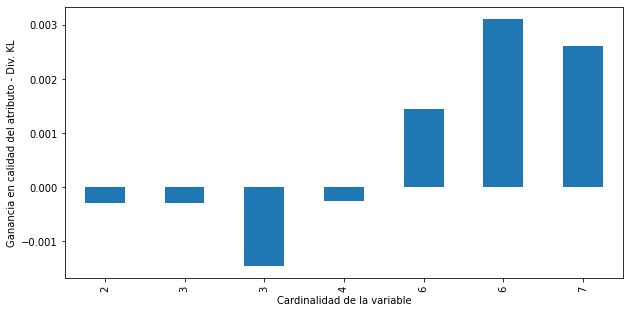

In [ ]:
plt.figure(figsize=(10, 5))
ax = pd.Series(np.mean(divergencia_kl_igual_budget, axis=0) - np.mean(divergencia_kl_budget_cat, axis=0), index=cardinalidad).sort_index().plot.bar()
ax.set_ylabel('Ganancia en calidad del atributo - Div. KL')
ax.set_xlabel('Cardinalidad de la variable')

Lo que se verifica, al igual que con el set de datos I, es que esta nueva estrategia de asignación del budget permitió mejorar la calidad de las variables con más categorías, mientras que se deterioran las variables de menos categorías. No obstante, visto globalmente, esta modificación permitió una mejora en la calidad de la información.

## 3.2.3 Sensibilidad del error al tamaño del dataset

Para el conjunto de datos anterior pudimos establecer que la cantidad de datos con la que contamos es suficiente, pero limitada. De tener más, los resultados mejorarían en gran medida. Veamos ahora que pasa en relación a este conjunto de datos.

In [ ]:
error = []

for n_reg in range(100, 3050, 50):
  ds_boots = ds.sample(n=n_reg, replace=True)

  categorias = 0
  for (columnName, columnData) in ds_boots.iteritems():
    categorias+=len(columnData.unique())### Preciso saber de antemano el número de bins que hay.

  delta = 0.0005
  sens = np.sqrt(len(ds_boots.columns))
  epsilon_x_categoria = 4/categorias ### Estimo el budget que se asignará a cada categoria
  divergencia_kl_budget_cat = []
  error_absoluto_budget_cat = []
  for i in range(0,100):
    div_kl_hist = []
    error_abs_hist = []

    for (columnName, columnData) in ds_boots.iteritems():
      
      
      codes = pd.Categorical(columnData).codes###Extraigo la codificación numérica correspondiente a cada categoría. Es necesario para el funcionamiento de la función np.histogram
      n_cat = len(np.unique(codes))###Calculo la cantidad de bins que tendrá el histograma, que será uno por categoría de la variable.
      epsilon = n_cat*epsilon_x_categoria###A cada feature le asigno el budget proporcional a la cantidad de bin´s

      ###CON DP
      dp_hist, dp_bins = dp.tools.histogram(codes, mech='gauss', delta=delta, epsilon=epsilon ,sens=sens, bins=n_cat)

      ###Sin DP
      hist, bins = np.histogram(codes, bins=n_cat)
      hist = hist / hist.sum()

      ###Error
      div_kl_hist.append(kl(hist, dp_hist))
      error_abs_hist.append(np.abs(hist - dp_hist).sum())

    divergencia_kl_budget_cat.append(div_kl_hist)
    error_absoluto_budget_cat.append(error_abs_hist)

  divergencia_kl_budget_cat = np.mean(divergencia_kl_budget_cat, axis=0)
  error_absoluto_budget_cat = np.mean(error_absoluto_budget_cat, axis=0)

  error.append([n_reg, np.mean(divergencia_kl_budget_cat), np.mean(error_absoluto_budget_cat)])

In [ ]:
error = pd.DataFrame(error)
error.columns = ['Tamaño del dataset', 'Divergencia KL', 'Error absoluto']
error

,Tamaño del dataset,Divergencia KL,Error absoluto
0,100,1.473766,0.459115
1,150,0.727532,0.329503
2,200,0.448271,0.262650
3,250,0.289059,0.211545
4,300,0.225126,0.184848
5,350,0.150167,0.159759
6,400,0.083755,0.135477
7,450,0.053809,0.117988
8,500,0.052724,0.112279
9,550,0.034032,0.101602


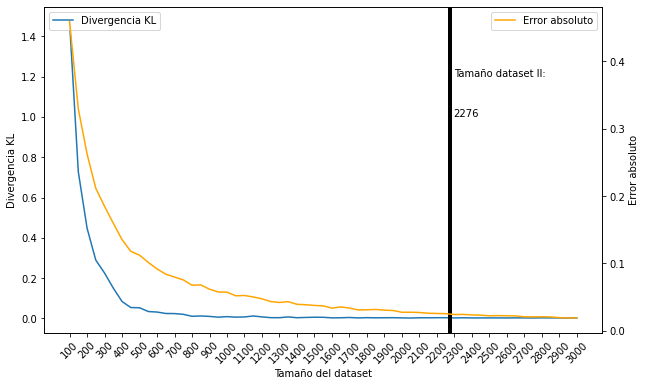

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))

ax.plot(error['Tamaño del dataset'], error['Divergencia KL'])

ax2 = ax.twinx()

ax2.plot(error['Tamaño del dataset'], error['Error absoluto'], color='orange')

ax.axvline(x=len(ds), linewidth=4, color='black')
ax.text(len(ds)+20, 1.2, 'Tamaño dataset II:')
ax.text(len(ds)+20, 1, str(len(ds)))

ax.set_xticks([x for x in error['Tamaño del dataset'] if x%100 == 0])
ax.set_xticklabels([x for x in error['Tamaño del dataset'] if x%100 == 0], rotation='45', size = 10)
ax.set_xlabel('Tamaño del dataset')
ax.set_ylabel('Divergencia KL')
###ax.set_title('Error del mecanismo DP en función del tamaño del dataset', size = 25)

ax2.set_ylabel('Error absoluto')

ax.legend(['Divergencia KL'], loc = 2)
ax2.legend(['Error absoluto'], loc = 1)

A diferencia de lo que pasaba en el caso anterior, donde el ruido introducido era muy elevado en función de la cantidad de observaciones en el dataset, para este conjunto de datos, la cantidad de observaciones que tenemos es óptima dadas las consultas que estamos realizando.

Es interesante notar, dadas las diferencias entre este caso y el del notebook 2.2, como impactan sobre la calidad de la salida tanto la cantidad de consultas que se realizan, como el tamaño del dataset. Esto reafirma lo que la teoría nos indicaba: los mecanismos de DP son intensivos en ingesta de datos y existe una relación inversa entre la cantidad de consultas que podemos hacer y la calidad de la salida. 

## 3.2.4 Conclusiones del apartado

*   En base al conjunto de datos disponible, es posible aplicar un mecanismo de DP que permita liberar información útil, garantizando niveles aceptables de privacidad. La calidad de la salida alcanzada es muy elevada.
*   Una vez aplicada la ingeniería de atributos propuesta en el notebook 3.1, hemos determinado mantener los criterios utilizados en el notebook anterior: un mecanismo gaussiano con un budget de 4 $\epsilon$ y $\delta$ de 0.0005 por consulta. 
*   El tamaño del dataset resulta adecuado para las consultas realizadas.



